# Clustering

I am not very experienced at clustering, so i decided to just try out everything from [sklearn clustering manual](http://scikit-learn.org/stable/modules/clustering.html) to see what works and what not.

In [1]:
import pickle
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, AffinityPropagation, Birch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import matplotlib
from hyperopt import fmin, hp, tpe
from sklearn.decomposition import PCA
import numpy as np

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 8)

In [2]:
with open('./data/output.pickle', 'rb') as f:
    data = pickle.load(f)

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1159 samples in 0.002s...
[t-SNE] Computed neighbors for 1159 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1159
[t-SNE] Computed conditional probabilities for sample 1159 / 1159
[t-SNE] Mean sigma: 1.698633
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.051567
[t-SNE] Error after 1000 iterations: 0.938098


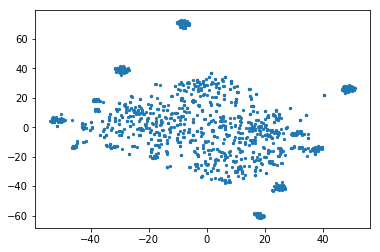

In [3]:
tsne = TSNE(n_components=2, verbose=True)
vectors_tsne = tsne.fit_transform(data['vectors'])
plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], s=5)
plt.show()

### PCA

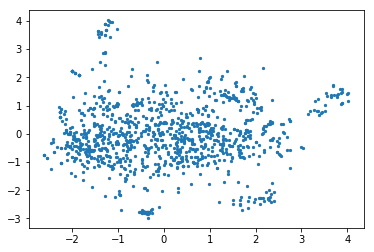

In [4]:
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(data['vectors'])
plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], s=5)
plt.show()

### Searching for parameters

In [5]:
def objective(hparams):
    klass, kwargs = hparams
    if 'n_clusters' in kwargs:
        kwargs['n_clusters'] = int(kwargs['n_clusters'])
        
    model = klass(**kwargs)
    cluster_ids = model.fit_predict(data['vectors'])
    
    if len(set(cluster_ids)) > 1:
        score = silhouette_score(data['vectors'], cluster_ids)
    else:
        score = -1
        
    return -score
    
hparams_space = hp.choice('method', [
    (KMeans, {
        'n_clusters': hp.quniform('kmeans_n_clusters', 2, 32, 1),
    }),
    (Birch, {
        'n_clusters': hp.quniform('birch_n_clusters', 2, 32, 1),
        'threshold': hp.uniform('threshold', 0.5, 8)
    }),
    (AffinityPropagation, {
        'damping': hp.uniform('damping', 0.5, 0.99)
    }),
    (DBSCAN, {
        'min_samples': hp.quniform('min_samples', 2, 32, 1),
        'eps': hp.loguniform('eps', np.log(0.01), np.log(1))
    }),
    (AgglomerativeClustering, {
        'n_clusters': hp.quniform('agglo_n_clusters', 2, 32, 1),
        'affinity': hp.choice('affinity', ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']),
        'linkage': hp.choice('linkage', ['complete', 'average'])
    })
])

hparams = fmin(objective, space=hparams_space, algo=tpe.suggest, max_evals=100, verbose=True)
print('best hparams: {}'.format(hparams))

/usr/local/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/usr/local/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: UserWarning: Number of subclusters found (1) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters))
/usr/local/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/usr/local/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: UserWarning: Number of subclusters found (1) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters))
/usr/local/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: UserWarning: Number of subclusters found (1) by Birch is less than (14). Decrease the threshold.
  % (len(cen

{'damping': 0.7908670972011537, 'method': 2}


Parameter search didn't give me any good solutions, resulting in models which cluster everything into one huge cluster with a couple outliers or making 30+ hard to interpret clusters. The next step was to try out elbow method, which didn't work so well either.

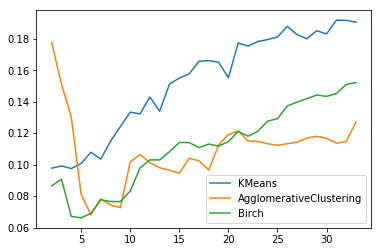

In [6]:
def plot_clustering_scores(build_model, label):
    n = 32
    scores = []
    for i in range(2, n + 2):
        model = build_model(i)
        cluster_ids = model.fit_predict(data['vectors'])
        score = silhouette_score(data['vectors'], cluster_ids)
        scores.append(score)
    plt.plot(range(2, n + 2), scores, label=label)

plot_clustering_scores(lambda i: KMeans(i), 'KMeans')
plot_clustering_scores(lambda i: AgglomerativeClustering(i, affinity='manhattan', linkage='average'), 'AgglomerativeClustering')
plot_clustering_scores(lambda i: Birch(n_clusters=i), 'Birch')

plt.legend()
plt.show()

Final model was picked by looking at computed clusters and images and choosing the one which gives visualy most pleasant results.

In [7]:
model = KMeans(n_clusters=9)
cluster_ids = model.fit_predict(data['vectors'])
print('score: {}'.format(silhouette_score(data['vectors'], cluster_ids)))
print('cluster_ids: {}'.format(set(cluster_ids)))
print('num_clusters: {}'.format(len(set(cluster_ids))))

score: 0.13735193014144897
cluster_ids: {0, 1, 2, 3, 4, 5, 6, 7, 8}
num_clusters: 9


### Plot resulting clusters

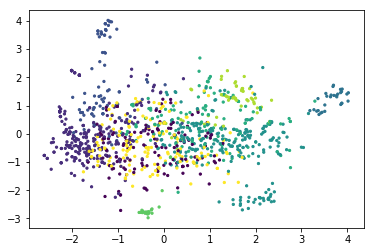

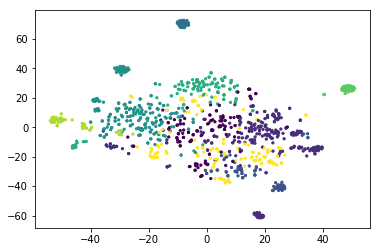

In [8]:
plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=cluster_ids, s=5)
plt.show()
plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], c=cluster_ids, s=5)
plt.show()

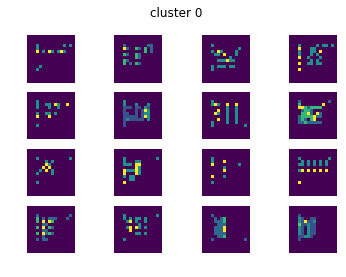

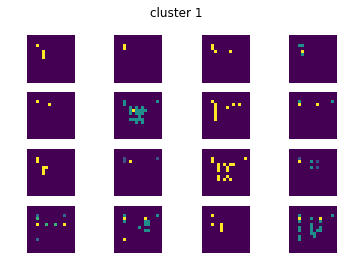

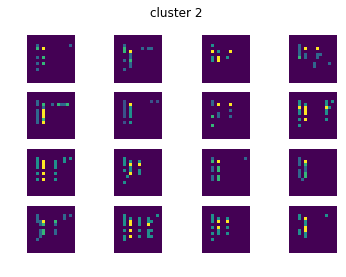

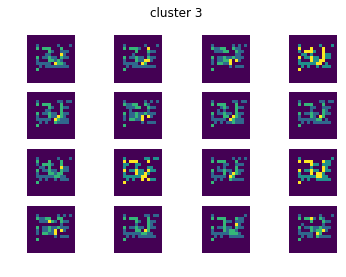

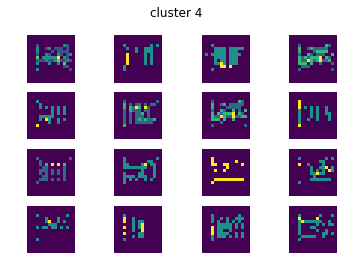

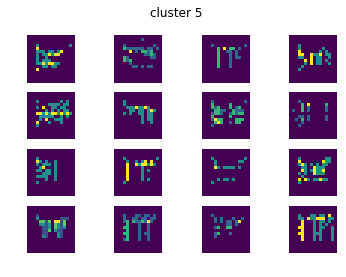

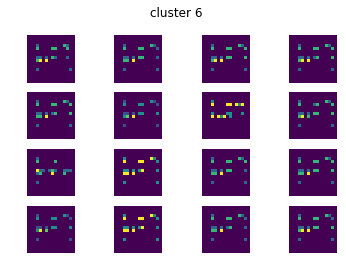

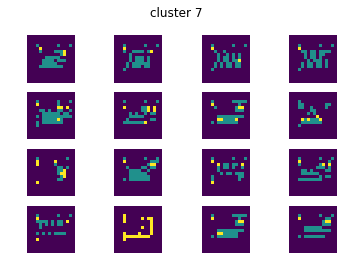

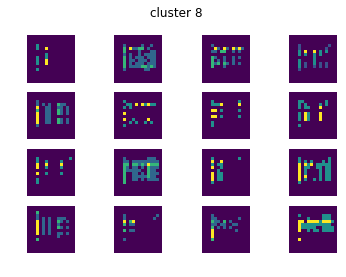

In [9]:
def tile_images(images, n):
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n, i * n + j + 1)
            plt.imshow(images[i * n + j].sum(-1))
            plt.axis('off')
            
n = 4
for c in set(cluster_ids):
    images = data['images'][cluster_ids == c]
    if images.shape[0] >= n**2:
        tile_images(images, n)
        plt.suptitle('cluster {}'.format(c))
        plt.show()